#### 讀檔

In [1]:
import os
import pandas as pd

def load_all_stock_data(folder_path):
    all_data = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".csv"):
            path = os.path.join(folder_path, filename)
            tic = filename.replace("converted_", "").replace(".csv", "")
            df = pd.read_csv(path)
            df['tic'] = tic  # 加上股票代碼欄位
            all_data.append(df)
    return pd.concat(all_data, ignore_index=True)

# 📂 資料夾路徑
folder_path = "/Users/gary/Documents/project/RL/code/converted_stock"

# 📈 載入所有股票資料
raw_df = load_all_stock_data(folder_path)

# # 🔍 查看資料概況
# print(raw_df.shape)
# print(raw_df[['date', 'tic']].drop_duplicates().head())


#### 補值

In [2]:
import pandas as pd
import numpy as np

def interpolate_stock_data(df, start_date="2020-01-01", end_date="2024-10-30"):
    # 建立完整日期範圍（僅工作日）
    full_dates = pd.date_range(start=start_date, end=end_date, freq='B')  # 'B' 是 business day

    result_list = []

    for tic in df['tic'].unique():
        sub_df = df[df['tic'] == tic].copy()
        sub_df['date'] = pd.to_datetime(sub_df['date'])

        # 設定 index 為日期後 reindex
        sub_df = sub_df.set_index('date').reindex(full_dates)
        sub_df['tic'] = tic  # 保留股票代碼欄位
        sub_df.index.name = 'date'

        # 線性補值（針對數值欄位）
        num_cols = ['open', 'high', 'low', 'close', 'volume']
        for col in num_cols:
            if col in sub_df.columns:
                sub_df[col] = sub_df[col].interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')

        result_list.append(sub_df.reset_index())

    # 合併所有股票資料
    full_df = pd.concat(result_list, ignore_index=True)
    return full_df

# 📈 執行補值
interpolated_df = interpolate_stock_data(raw_df)

# 🔍 檢查結果
print(interpolated_df.shape)
print(interpolated_df.head())


(12610, 7)
        date       open       high        low      close     volume      tic
0 2020-01-01  80.399082  80.399082  79.836291  80.077484  3326184.0  1301.TW
1 2020-01-02  80.399082  80.399082  79.836291  80.077484  3326184.0  1301.TW
2 2020-01-03  80.077488  81.605072  79.836295  81.605072  5636265.0  1301.TW
3 2020-01-06  81.605077  82.007072  81.203082  82.007072  6514815.0  1301.TW
4 2020-01-07  81.605072  82.007067  81.203077  81.605072  6945442.0  1301.TW


/var/folders/gb/ywzbr8qs2734zggdmvx949780000gn/T/ipykernel_51948/1499623503.py:23: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sub_df[col] = sub_df[col].interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
/var/folders/gb/ywzbr8qs2734zggdmvx949780000gn/T/ipykernel_51948/1499623503.py:23: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sub_df[col] = sub_df[col].interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
/var/folders/gb/ywzbr8qs2734zggdmvx949780000gn/T/ipykernel_51948/1499623503.py:23: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sub_df[col] = sub_df[col].interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
/var/folders/gb/ywzbr8qs2734zggdmvx94978000

#### DTW分群

In [3]:
from sklearn.preprocessing import MinMaxScaler
from tslearn.metrics import cdist_dtw
from pyclustering.cluster.kmedoids import kmedoids
import matplotlib.pyplot as plt
import matplotlib.cm as cm

/Users/gary/Documents/project/water/water_venv/lib/python3.10/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [4]:
def calculate_log_return(df):
    df['date'] = pd.to_datetime(df['date'])
    result = {}

    for tic in df['tic'].unique():
        sub_df = df[df['tic'] == tic].copy().set_index('date').sort_index()
        sub_df['log_return'] = np.log(sub_df['close'] / sub_df['close'].shift(1))
        result[tic] = sub_df['log_return'].dropna()

    return pd.DataFrame(result)


In [5]:
def calculate_log_return(df):
    df['date'] = pd.to_datetime(df['date'])
    result = {}

    for tic in df['tic'].unique():
        sub_df = df[df['tic'] == tic].copy().set_index('date').sort_index()
        sub_df['log_return'] = np.log(sub_df['close'] / sub_df['close'].shift(1))
        result[tic] = sub_df['log_return'].dropna()

    return pd.DataFrame(result)


In [6]:

def dtw_cluster(log_return_df, k=3):
    series_array = log_return_df.T.values[..., np.newaxis]
    dist_matrix = cdist_dtw(series_array)
    initial_medoids = list(range(k))

    kmedoids_instance = kmedoids(dist_matrix, initial_medoids, data_type='distance_matrix', ccore=False)
    kmedoids_instance.process()
    clusters = kmedoids_instance.get_clusters()

    label_map = {}
    stock_list = list(log_return_df.columns)
    for i, cluster in enumerate(clusters):
        for idx in cluster:
            label_map[stock_list[idx]] = i
    return label_map


In [7]:
def plot_clusters(log_return_df, cluster_labels):
    grouped_stocks = {}
    for stock, group in cluster_labels.items():
        grouped_stocks.setdefault(group, []).append(stock)

    for group_id, stocks in grouped_stocks.items():
        plt.figure(figsize=(12, 4))
        for stock in stocks:
            plt.plot(log_return_df.index, log_return_df[stock], label=stock)
        plt.title(f"group {group_id}:no.{len(stocks)} ")
        plt.xlabel("date")
        plt.ylabel("normalization Log Return")
        plt.legend(loc='upper right')
        plt.grid(True)
        plt.tight_layout()
        plt.show()


/var/folders/gb/ywzbr8qs2734zggdmvx949780000gn/T/ipykernel_51948/1499623503.py:23: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sub_df[col] = sub_df[col].interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
/var/folders/gb/ywzbr8qs2734zggdmvx949780000gn/T/ipykernel_51948/1499623503.py:23: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sub_df[col] = sub_df[col].interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
/var/folders/gb/ywzbr8qs2734zggdmvx949780000gn/T/ipykernel_51948/1499623503.py:23: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sub_df[col] = sub_df[col].interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
/var/folders/gb/ywzbr8qs2734zggdmvx94978000

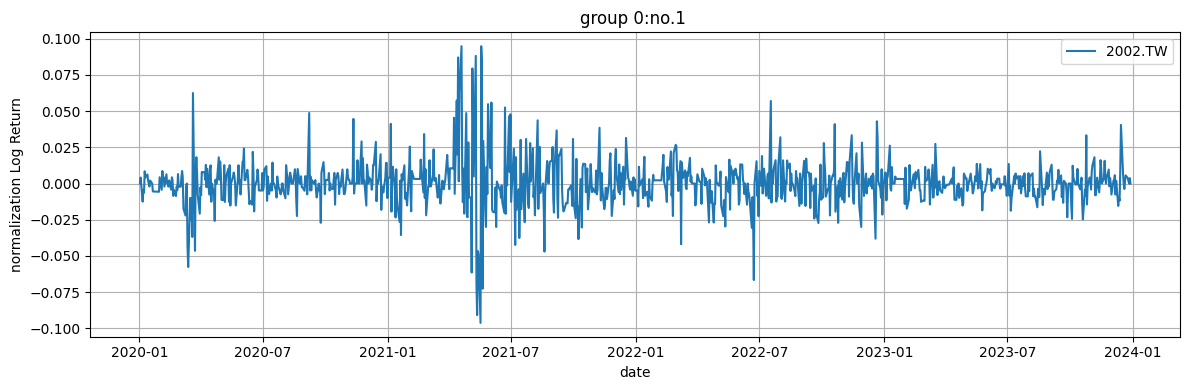

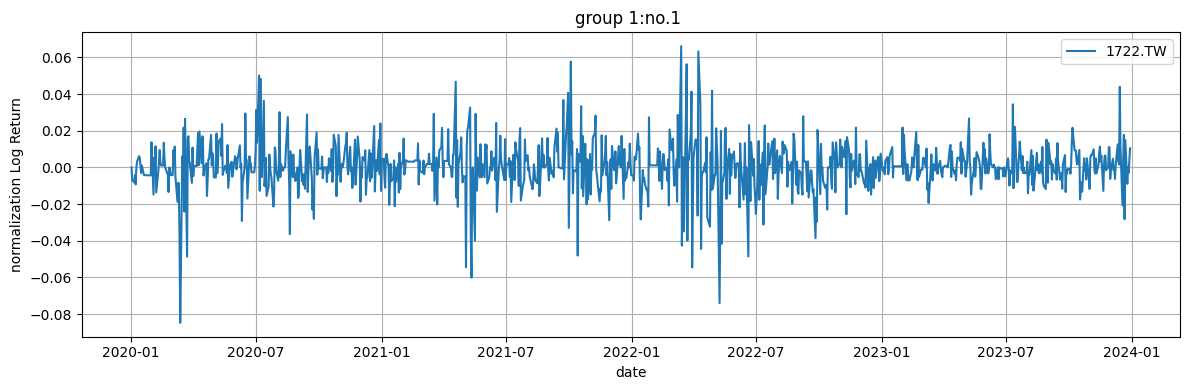

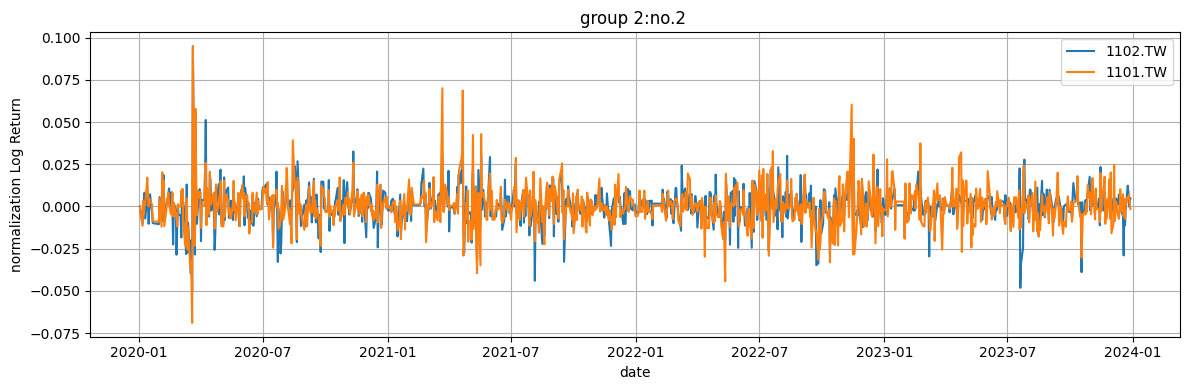

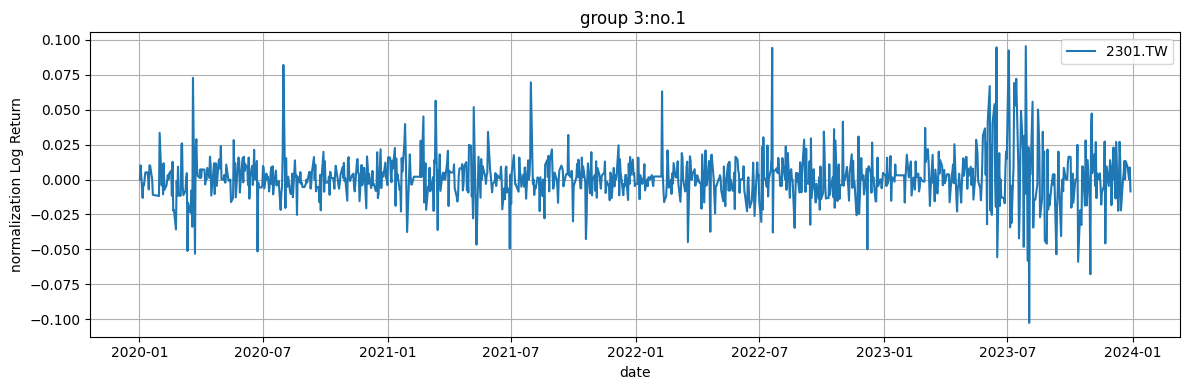

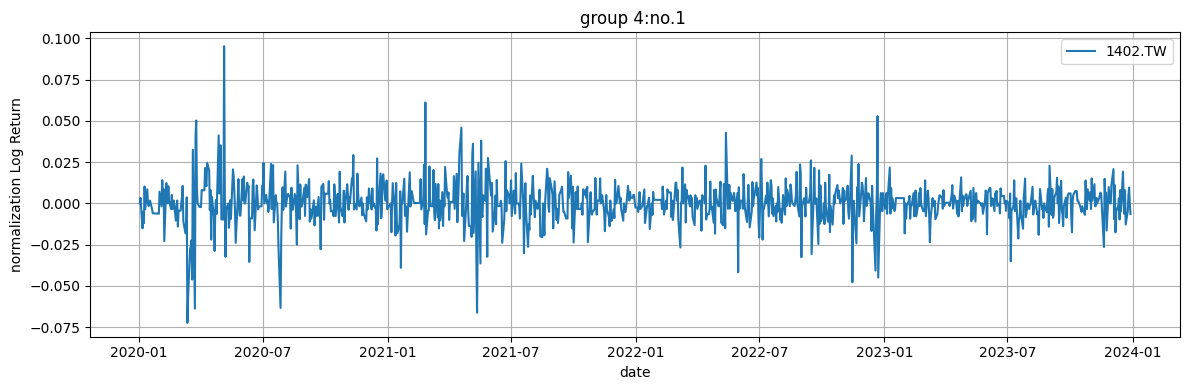

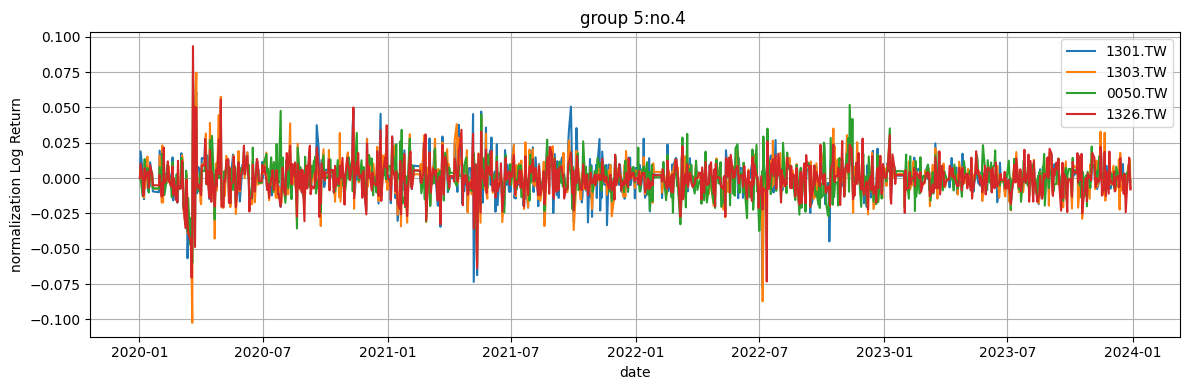

In [8]:
# 讀取資料夾中所有股票 CSV
def load_all_stock_data(folder_path):
    all_data = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".csv"):
            path = os.path.join(folder_path, filename)
            tic = filename.replace("converted_", "").replace(".csv", "")
            df = pd.read_csv(path)
            df['tic'] = tic
            all_data.append(df)
    return pd.concat(all_data, ignore_index=True)

# 讀取 + 補值
folder_path = "/Users/gary/Documents/project/RL/code/converted_stock"
raw_df = load_all_stock_data(folder_path)
interpolated_df = interpolate_stock_data(raw_df)

# 計算 log return 並切割訓練集（只用到 2023-12-31）
log_return_df = calculate_log_return(interpolated_df)
train_log_return_df = log_return_df[log_return_df.index <= '2023-12-31']

# 正規化並分群
cluster_labels = dtw_cluster(train_log_return_df, k=6)

# 畫出分群結果
plot_clusters(train_log_return_df, cluster_labels)


### train model

In [9]:
import os
from finrl.agents.stablebaselines3.models import DRLAgent
from stable_baselines3 import PPO
from finrl.meta.env_stock_trading.env_stocktrading_np import StockTradingEnv
import numpy as np

#### 訓練

##### 環境

In [10]:
import gym
import numpy as np
from gym import spaces

class CustomStockTradingEnv(gym.Env):
    def __init__(self, config):
        super(CustomStockTradingEnv, self).__init__()

        self.price_array = config['price_array']
        self.tech_array = config['tech_array']
        self.turbulence_array = config['turbulence_array']
        self.initial_amount = config.get('initial_amount', 1e6)
        self.buy_cost_pct = config.get('buy_cost_pct', 0.001)
        self.sell_cost_pct = config.get('sell_cost_pct', 0.001)
        self.reward_scaling = config.get('reward_scaling', 1e-4)
        self.if_train = config.get('if_train', True)
        self.max_stock = config.get('max_stock', 1e4)
        self.min_trade_unit = config.get('min_trade_unit', 1)

        self.day = 0
        self.data_length, self.stock_dim = self.price_array.shape

        self.action_space = spaces.Box(low=-1, high=1, shape=(self.stock_dim,), dtype=np.float32)
        obs_dim = 1 + self.stock_dim + self.price_array.shape[1] + self.tech_array.shape[1]
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(obs_dim,), dtype=np.float32)



        self.reset()

    def reset(self):
        self.day = 0
        self.amount = self.initial_amount
        self.stocks = np.zeros(self.stock_dim, dtype=np.float32)
        self.total_asset = self.amount
        self.asset_memory = [self.total_asset]
        return self._get_observation()

    def step(self, actions):
        actions = actions * self.max_stock
        actions = np.round(actions / self.min_trade_unit) * self.min_trade_unit

        begin_total_asset = self._calculate_total_asset()
        prices = self.price_array[self.day]

        # 停損邏輯（賣出前一天跌超過 10%）
        if self.day > 0:
            prev_prices = self.price_array[self.day - 1]
            price_change = (prices - prev_prices) / prev_prices
            for i in range(self.stock_dim):
                if price_change[i] < -0.10 and self.stocks[i] > 0:
                    # 強制停損
                    slippage = np.random.normal(0, 0.005) if self.if_train else 0.0
                    traded_price = prices[i] * (1 + slippage)
                    proceeds = self.stocks[i] * traded_price * (1 - self.sell_cost_pct)
                    self.amount += proceeds
                    self.stocks[i] = 0

        for i in range(self.stock_dim):
            action = actions[i]
            price = prices[i]
            if np.isnan(price) or price < 1e-6:
                continue

            slippage = np.random.normal(0, 0.005) if self.if_train else 0.0
            traded_price = price * (1 + slippage)

            # Buy
            if action > 0:
                max_buyable = min(
                    (self.amount // (traded_price * (1 + self.buy_cost_pct))),
                    self.max_stock - self.stocks[i]
                )
                trade_amount = min(action, max_buyable)
                cost = trade_amount * traded_price * (1 + self.buy_cost_pct)
                self.amount -= cost
                self.stocks[i] += trade_amount

            # Sell
            elif action < 0:
                trade_amount = min(-action, self.stocks[i])
                proceeds = trade_amount * traded_price * (1 - self.sell_cost_pct)
                self.amount += proceeds
                self.stocks[i] -= trade_amount

        self.day += 1
        done = self.day >= self.data_length - 1

        end_total_asset = self._calculate_total_asset()
        reward = (end_total_asset - begin_total_asset) * self.reward_scaling
        self.total_asset = end_total_asset
        self.asset_memory.append(self.total_asset)

        # ✅ 每日資產增幅過大時，強制 done
        daily_return = (end_total_asset - begin_total_asset) / begin_total_asset
        if daily_return > 1.0:  # 超過 +100%
            print("⚠️ Daily return too high, forcing stop.")
            done = True

        # ✅ 最大回撤限制（-30%）
        peak = max(self.asset_memory[:-1]) if len(self.asset_memory) > 1 else self.initial_amount
        drawdown = (end_total_asset - peak) / peak
        if drawdown < -0.3:
            print("⚠️ Max drawdown triggered, forcing stop.")
            done = True

        return self._get_observation(), reward, done, {}

    def _get_observation(self):
        obs = np.concatenate([
            [self.amount],
            self.stocks,
            self.price_array[self.day],
            self.tech_array[self.day].flatten()
        ])
        return obs

    def _calculate_total_asset(self):
        return self.amount + np.sum(self.stocks * self.price_array[self.day])

    def render(self, mode='human'):
        print(f"day {self.day}, total_asset: {self.total_asset}")

###### veraion 1

In [11]:
# # 建立強化學習環境，支援單支或多支股票
# def create_env_for_stock_np(df, stock_tic, indicators, initial_amount=1e6, if_train=True):
#     if isinstance(stock_tic, str):
#         stock_list = [stock_tic]
#     else:
#         stock_list = stock_tic

#     df = df[df['tic'].isin(stock_list)].copy()
#     df = df.sort_values(['date', 'tic']).reset_index(drop=True)
#     df[indicators] = df[indicators].fillna(0)

#     unique_dates = sorted(df['date'].unique())
#     price_array = df.pivot(index='date', columns='tic', values='close').reindex(unique_dates).values

#     # 技術指標 flatten
#     tech_features = []
#     for date in unique_dates:
#         date_data = df[df['date'] == date]
#         row = []
#         for tic in stock_list:
#             sub = date_data[date_data['tic'] == tic]
#             if not sub.empty:
#                 row.extend(sub[indicators].values.flatten().tolist())
#             else:
#                 row.extend([0.0] * len(indicators))
#         tech_features.append(row)
#     tech_array = np.array(tech_features)

#     turbulence_array = np.zeros(len(price_array))

#     env = CustomStockTradingEnv(
#         config={
#             "price_array": price_array,
#             "tech_array": tech_array,
#             "turbulence_array": turbulence_array,
#             "if_add_price": True,
#             "if_add_tech": True,
#             "if_add_turbulence": False,
#             "risk_indicator_col": "turbulence",
#             "initial_amount": initial_amount,
#             "buy_cost_pct": 0.001,
#             "sell_cost_pct": 0.001,
#             "reward_scaling": 1e-4,
#             "if_train": if_train
#         }
#     )
#     return env

###### veraion 2

In [12]:
def create_env_for_stock_np(
    df,
    stock_tic,
    indicators,
    initial_amount=1e6,
    if_train=True,
    max_stock=1e4,
    slippage_pct=0.005,  # 滑價 ±0.5%
    min_trade_unit=1     # 最小交易單位（整數）
):

    # ✅ 選擇群內所有股票（多支）
    df = df[df['tic'].isin(stock_tic)].copy()
    df = df.sort_values(['date', 'tic']).reset_index(drop=True)

    # 補值處理
    df[indicators] = df[indicators].fillna(0)

    unique_dates = sorted(df['date'].unique())

    # 🎯 建構 Numpy 格式
    price_array = df.pivot(index='date', columns='tic', values='close').reindex(unique_dates).values
    tech_array = df.pivot(index='date', columns='tic', values=indicators).reindex(unique_dates).values
    turbulence_array = np.zeros(len(unique_dates))  # 無 turbulence 就全零

    # ✅ 實作滑價邏輯（train 才加隨機 slippage）
    if if_train:
        rng = np.random.default_rng()
        price_array = price_array * (1 + rng.normal(loc=0.0, scale=slippage_pct, size=price_array.shape))

    # ✅ 將價格為負數/零的異常點清掉
    price_array = np.clip(price_array, a_min=1e-3, a_max=None)

    # ✅ 整合環境
    env = CustomStockTradingEnv(
        config={
            "price_array": price_array,
            "tech_array": tech_array,
            "turbulence_array": turbulence_array,
            "if_add_price": True,
            "if_add_tech": True,
            "if_add_turbulence": False,
            "risk_indicator_col": "turbulence",
            "initial_amount": initial_amount,
            "buy_cost_pct": 0.001,
            "sell_cost_pct": 0.001,
            "reward_scaling": 1e-4,
            "if_train": if_train,
            "max_stock": max_stock,             # ✅ 限制最大倉位
            "min_trade_unit": min_trade_unit    # ✅ 整數交易限制
        }
    )

    return env


##### 分群訓練

In [13]:
# 訓練特定群組的模型（該群所有股票）
def train_model_for_cluster(cluster_id, cluster_labels, df, indicators, model_dir):
    group_stocks = [tic for tic, g in cluster_labels.items() if g == cluster_id]
    print(f"🧠 訓練群 {cluster_id}：{group_stocks}")

    # 訓練資料：2021 ~ 2023
    train_data = df[(df['date'] >= '2020-01-01') & (df['date'] <= '2023-12-31')]
    
    env = create_env_for_stock_np(train_data, stock_tic=group_stocks, indicators=indicators, if_train=True)
    agent = DRLAgent(env=env)
    model = agent.get_model("ppo")
    trained_model = agent.train_model(model=model, tb_log_name=f"ppo_cluster_{cluster_id}", total_timesteps=300_000)

    model_path = os.path.join(model_dir, f"ppo_cluster_{cluster_id}.zip")
    trained_model.save(model_path)
    print(f"✅ 模型儲存於：{model_path}")
    return model_path

# 批次訓練所有群組模型
def train_all_models(cluster_labels, df, indicators, model_dir):
    for cluster_id in sorted(set(cluster_labels.values())):
        train_model_for_cluster(
            cluster_id=cluster_id,
            cluster_labels=cluster_labels,
            df=df,
            indicators=indicators,
            model_dir=model_dir
        )

In [14]:
from stockstats import StockDataFrame

def add_technical_indicators(df, indicators=["macd", "rsi_30", "cci_30", "wr_14"]):
    df_list = []
    for tic in df['tic'].unique():
        sub_df = df[df['tic'] == tic].copy()
        sub_df = sub_df.sort_values("date")
        stock = StockDataFrame.retype(sub_df)

        for indicator in indicators:
            try:
                sub_df[indicator] = stock[indicator]
            except Exception as e:
                print(f"⚠️ {tic} 無法計算 {indicator}：{e}")

        if 'date' not in sub_df.columns:
            sub_df['date'] = sub_df.index

        df_list.append(sub_df)

    return pd.concat(df_list).reset_index(drop=True)


In [15]:
# 參數
model_dir = "/Users/gary/Documents/project/RL/code/model"
indicators = ["macd", "rsi_30", "cci_30", "wr_14"]

interpolated_df = add_technical_indicators(interpolated_df, indicators=indicators)

# 訓練所有模型（每群一個）
train_all_models(cluster_labels=cluster_labels, df=interpolated_df, indicators=indicators, model_dir=model_dir)

# 測試指定股票（如 1101.TW）



🧠 訓練群 0：['2002.TW']
{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 64}
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/Users/gary/Documents/project/water/water_venv/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


-------------------------------------
| rollout/           |              |
|    ep_len_mean     | 1.04e+03     |
|    ep_rew_mean     | -11.8        |
| time/              |              |
|    fps             | 7089         |
|    iterations      | 1            |
|    time_elapsed    | 0            |
|    total_timesteps | 2048         |
| train/             |              |
|    reward          | -0.044515442 |
-------------------------------------
-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 1.04e+03      |
|    ep_rew_mean          | -2.89         |
| time/                   |               |
|    fps                  | 4351          |
|    iterations           | 2             |
|    time_elapsed         | 0             |
|    total_timesteps      | 4096          |
| train/                  |               |
|    approx_kl            | 0.0019509192  |
|    clip_fraction        | 0.0109        |
|    clip_range 

/Users/gary/Documents/project/water/water_venv/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.04e+03 |
|    ep_rew_mean     | 4.31     |
| time/              |          |
|    fps             | 5154     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
| train/             |          |
|    reward          | 0.0      |
---------------------------------
⚠️ Max drawdown triggered, forcing stop.
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 963         |
|    ep_rew_mean          | -6.56       |
| time/                   |             |
|    fps                  | 2770        |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.004275822 |
|    clip_fraction        | 0.0162      |
|    clip_range           | 0.2         |
|    

/Users/gary/Documents/project/water/water_venv/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


----------------------------------
| rollout/           |           |
|    ep_len_mean     | 1.04e+03  |
|    ep_rew_mean     | -8.45     |
| time/              |           |
|    fps             | 6970      |
|    iterations      | 1         |
|    time_elapsed    | 0         |
|    total_timesteps | 2048      |
| train/             |           |
|    reward          | 0.8228195 |
----------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.04e+03    |
|    ep_rew_mean          | -14.6       |
| time/                   |             |
|    fps                  | 4620        |
|    iterations           | 2           |
|    time_elapsed         | 0           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.002853807 |
|    clip_fraction        | 0.0222      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.83 

/Users/gary/Documents/project/water/water_venv/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


⚠️ Max drawdown triggered, forcing stop.
------------------------------------
| rollout/           |             |
|    ep_len_mean     | 984         |
|    ep_rew_mean     | -3.91       |
| time/              |             |
|    fps             | 5818        |
|    iterations      | 1           |
|    time_elapsed    | 0           |
|    total_timesteps | 2048        |
| train/             |             |
|    reward          | -0.19462699 |
------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.01e+03     |
|    ep_rew_mean          | 2.22         |
| time/                   |              |
|    fps                  | 3769         |
|    iterations           | 2            |
|    time_elapsed         | 1            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0008968646 |
|    clip_fraction        | 0.0105       |

/Users/gary/Documents/project/water/water_venv/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.04e+03 |
|    ep_rew_mean     | -9.29    |
| time/              |          |
|    fps             | 7236     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
| train/             |          |
|    reward          | 0.0      |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.04e+03     |
|    ep_rew_mean          | -13.4        |
| time/                   |              |
|    fps                  | 4701         |
|    iterations           | 2            |
|    time_elapsed         | 0            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.003586765  |
|    clip_fraction        | 0.0345       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.42

/Users/gary/Documents/project/water/water_venv/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


⚠️ Max drawdown triggered, forcing stop.
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 608       |
|    ep_rew_mean     | -23.1     |
| time/              |           |
|    fps             | 6705      |
|    iterations      | 1         |
|    time_elapsed    | 0         |
|    total_timesteps | 2048      |
| train/             |           |
|    reward          | 0.6463541 |
----------------------------------
⚠️ Max drawdown triggered, forcing stop.
⚠️ Max drawdown triggered, forcing stop.
⚠️ Max drawdown triggered, forcing stop.
⚠️ Max drawdown triggered, forcing stop.
⚠️ Max drawdown triggered, forcing stop.
⚠️ Max drawdown triggered, forcing stop.
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | -25.6       |
| time/                   |             |
|    fps                  | 4535        |
|    iterations           | 2           |

#### 測試

In [16]:
def test_model_by_tic(cluster_labels, test_tic, df, indicators, model_dir, initial_amount=1e6):
    from stable_baselines3 import PPO
    from stable_baselines3.common.vec_env import DummyVecEnv
    import matplotlib.pyplot as plt
    import numpy as np
    import os

    if test_tic not in cluster_labels:
        raise ValueError(f"{test_tic} not found in cluster_labels.")

    group_id = cluster_labels[test_tic]
    model_path = os.path.join(model_dir, f"ppo_cluster_{group_id}.zip")
    print(f"📁 Using model for cluster {group_id}: {model_path}")

    # 取得群內所有股票
    group_stocks = [tic for tic, g in cluster_labels.items() if g == group_id]
    test_data = df[
        (df['date'] >= '2024-01-01') &
        (df['date'] <= '2024-10-30') &
        (df['tic'].isin(group_stocks))
    ].copy()

    # 建立測試環境
    def make_env():
        return create_env_for_stock_np(test_data, stock_tic=group_stocks, indicators=indicators, if_train=False)

    vec_env = DummyVecEnv([make_env])
    raw_env = vec_env.envs[0]

    # ✅ 載入模型但不立即綁定環境，避免自動比對失敗
    model = PPO.load(model_path, device="auto")
    model.set_env(vec_env)

    obs = vec_env.reset()
    asset_history = []
    date_memory = sorted(test_data['date'].unique())
    step = 0

    while True:
        action, _ = model.predict(obs)
        obs, reward, done, info = vec_env.step(action)

        current_asset = raw_env.amount + (raw_env.price_array[raw_env.day - 1] * raw_env.stocks).sum()

        if done:
            asset_history.append(current_asset)
            print("🧪 Final step info:")
            print(f"  step: {step}")
            print(f"  amount: {raw_env.amount}")
            print(f"  price_array: {raw_env.price_array[raw_env.day - 1]}")
            print(f"  stocks: {raw_env.stocks}")
            break

        asset_history.append(current_asset)
        step += 1

    # 對齊日期長度
    asset_memory = np.array(asset_history)
    date_memory = date_memory[:len(asset_memory)]

    # ✅ 自動偵測資產暴跌
    if len(asset_memory) >= 2 and asset_memory[-1] < asset_memory[-2] * 0.5:
        print("⚠️ Final asset drop detected, removing last point.")
        asset_memory = asset_memory[:-1]
        date_memory = date_memory[:-1]

    # 📊 統計指標
    final_value = asset_memory[-1]
    returns = asset_memory / initial_amount - 1
    peak = np.maximum.accumulate(asset_memory)
    drawdown = (asset_memory - peak) / peak
    max_drawdown = drawdown.min()
    daily_returns = np.diff(asset_memory) / asset_memory[:-1]
    sharpe_ratio = np.mean(daily_returns) / np.std(daily_returns) * np.sqrt(252) if np.std(daily_returns) > 0 else np.nan

    # 📈 圖表
    plt.figure(figsize=(10, 4))
    plt.plot(date_memory, asset_memory, label="Portfolio Value")
    plt.xlabel("Date")
    plt.ylabel("Asset Value")
    plt.title(f"Backtest of cluster {group_id} (target: {test_tic})")
    plt.grid(True)
    plt.tight_layout()
    plt.legend()
    plt.xticks(rotation=45)

    output_path = f"/Users/gary/Documents/project/RL/code/result_image/{test_tic}.png"
    plt.savefig(output_path)
    print(f"🖼️ Backtest chart saved to: {output_path}")
    plt.show()

    # 📋 輸出績效
    print(f"📌 Final Portfolio Value: ${final_value:,.2f}")
    print(f"📈 Cumulative Return: {returns[-1]*100:.2f}%")
    print(f"📉 Max Drawdown: {max_drawdown*100:.2f}%")
    print(f"📊 Sharpe Ratio: {sharpe_ratio:.2f}")
    print("Asset history (tail):", asset_memory[-5:])


In [17]:
my_stocks = ["0050.TW", "1101.TW", "1102.TW", "1301.TW", "1303.TW",
             "1326.TW", "1402.TW", "1722.TW", "2002.TW", "2301.TW"]

def test_multiple_stocks_by_tic_list(tic_list, cluster_labels, df, indicators, model_dir, initial_amount=1e6):
    import traceback

    for test_tic in tic_list:
        print(f"\n======================")
        print(f"📊 Testing {test_tic}")
        print(f"======================")
        try:
            test_model_by_tic(
                cluster_labels=cluster_labels,
                test_tic=test_tic,
                df=df,
                indicators=indicators,
                model_dir=model_dir,
                initial_amount=initial_amount
            )
        except Exception as e:
            print(f"❌ Error testing {test_tic}: {e}")
            traceback.print_exc()

test_multiple_stocks_by_tic_list(
    tic_list=my_stocks,
    cluster_labels=cluster_labels,
    df=interpolated_df,
    indicators=indicators,
    model_dir=model_dir
)



📊 Testing 0050.TW
📁 Using model for cluster 5: /Users/gary/Documents/project/RL/code/model/ppo_cluster_5.zip
🧪 Final step info:
  step: 216
  amount: 1000000.0
  price_array: [189.18521118  47.29999924  41.70000076  38.70000076]
  stocks: [0. 0. 0. 0.]
🖼️ Backtest chart saved to: /Users/gary/Documents/project/RL/code/result_image/0050.TW.png
📌 Final Portfolio Value: $1,000,000.00
📈 Cumulative Return: 0.00%
📉 Max Drawdown: -34.78%
📊 Sharpe Ratio: 0.26
Asset history (tail): [1489829.00141404 1480708.08667385 1492869.42932654 1490210.15374136
 1000000.        ]

📊 Testing 1101.TW
📁 Using model for cluster 2: /Users/gary/Documents/project/RL/code/model/ppo_cluster_2.zip
🧪 Final step info:
  step: 216
  amount: 1000000.0
  price_array: [31.95000076 46.65000153]
  stocks: [0. 0.]


/Users/gary/Documents/project/water/water_venv/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/var/folders/gb/ywzbr8qs2734zggdmvx949780000gn/T/ipykernel_51948/1350382374.py:90: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()
/Users/gary/Documents/project/water/water_venv/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


🖼️ Backtest chart saved to: /Users/gary/Documents/project/RL/code/result_image/1101.TW.png
📌 Final Portfolio Value: $1,000,000.00
📈 Cumulative Return: 0.00%
📉 Max Drawdown: -3.79%
📊 Sharpe Ratio: 0.03
Asset history (tail): [ 985561.16201916  983561.15438977  984061.14676037  985061.16964856
 1000000.        ]

📊 Testing 1102.TW
📁 Using model for cluster 2: /Users/gary/Documents/project/RL/code/model/ppo_cluster_2.zip
🧪 Final step info:
  step: 216
  amount: 1000000.0
  price_array: [31.95000076 46.65000153]
  stocks: [0. 0.]
🖼️ Backtest chart saved to: /Users/gary/Documents/project/RL/code/result_image/1102.TW.png
📌 Final Portfolio Value: $1,000,000.00
📈 Cumulative Return: 0.00%
📉 Max Drawdown: -3.86%
📊 Sharpe Ratio: 0.03
Asset history (tail): [ 977126.38815298  975136.94665759  975636.9390282   976636.96191638
 1000000.        ]

📊 Testing 1301.TW
📁 Using model for cluster 5: /Users/gary/Documents/project/RL/code/model/ppo_cluster_5.zip
🧪 Final step info:
  step: 216
  amount: 1000000

/var/folders/gb/ywzbr8qs2734zggdmvx949780000gn/T/ipykernel_51948/1350382374.py:90: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()
/Users/gary/Documents/project/water/water_venv/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/var/folders/gb/ywzbr8qs2734zggdmvx949780000gn/T/ipykernel_51948/1350382374.py:90: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()
/Users/gary/Documents/project/water/water_venv/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automaticall

🖼️ Backtest chart saved to: /Users/gary/Documents/project/RL/code/result_image/1301.TW.png
📌 Final Portfolio Value: $1,000,000.00
📈 Cumulative Return: 0.00%
📉 Max Drawdown: -35.10%
📊 Sharpe Ratio: 0.26
Asset history (tail): [1497217.44913544 1488051.59464325 1500273.54913391 1497603.0553862
 1000000.        ]

📊 Testing 1303.TW
📁 Using model for cluster 5: /Users/gary/Documents/project/RL/code/model/ppo_cluster_5.zip
🧪 Final step info:
  step: 216
  amount: 1000000.0
  price_array: [189.18521118  47.29999924  41.70000076  38.70000076]
  stocks: [0. 0. 0. 0.]
🖼️ Backtest chart saved to: /Users/gary/Documents/project/RL/code/result_image/1303.TW.png
📌 Final Portfolio Value: $1,000,000.00
📈 Cumulative Return: 0.00%
📉 Max Drawdown: -35.88%
📊 Sharpe Ratio: 0.27
Asset history (tail): [1515368.07497579 1506091.15836889 1518460.81091101 1515755.96696646
 1000000.        ]

📊 Testing 1326.TW
📁 Using model for cluster 5: /Users/gary/Documents/project/RL/code/model/ppo_cluster_5.zip
🧪 Final step 

/var/folders/gb/ywzbr8qs2734zggdmvx949780000gn/T/ipykernel_51948/1350382374.py:90: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()
/Users/gary/Documents/project/water/water_venv/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/var/folders/gb/ywzbr8qs2734zggdmvx949780000gn/T/ipykernel_51948/1350382374.py:90: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()
/Users/gary/Documents/project/water/water_venv/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automaticall

🖼️ Backtest chart saved to: /Users/gary/Documents/project/RL/code/result_image/1326.TW.png
📌 Final Portfolio Value: $1,000,000.00
📈 Cumulative Return: 0.00%
📉 Max Drawdown: -35.84%
📊 Sharpe Ratio: 0.27
Asset history (tail): [1514376.98733224 1505105.7889222  1517467.55061425 1514764.59309468
 1000000.        ]

📊 Testing 1402.TW
📁 Using model for cluster 4: /Users/gary/Documents/project/RL/code/model/ppo_cluster_4.zip
🧪 Final step info:
  step: 216
  amount: 1000000.0
  price_array: [37.09999847]
  stocks: [0.]
🖼️ Backtest chart saved to: /Users/gary/Documents/project/RL/code/result_image/1402.TW.png
📌 Final Portfolio Value: $1,000,000.00
📈 Cumulative Return: 0.00%
📉 Max Drawdown: -7.58%
📊 Sharpe Ratio: 0.06
Asset history (tail): [1059997.72457109 1061997.73220048 1070497.71694169 1067997.71694169
 1000000.        ]

📊 Testing 1722.TW
📁 Using model for cluster 1: /Users/gary/Documents/project/RL/code/model/ppo_cluster_1.zip
🧪 Final step info:
  step: 216
  amount: 1000000.0
  price_arr

/var/folders/gb/ywzbr8qs2734zggdmvx949780000gn/T/ipykernel_51948/1350382374.py:90: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()
/Users/gary/Documents/project/water/water_venv/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/var/folders/gb/ywzbr8qs2734zggdmvx949780000gn/T/ipykernel_51948/1350382374.py:90: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()
/Users/gary/Documents/project/water/water_venv/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automaticall

🖼️ Backtest chart saved to: /Users/gary/Documents/project/RL/code/result_image/1722.TW.png
📌 Final Portfolio Value: $1,000,000.00
📈 Cumulative Return: 0.00%
📉 Max Drawdown: -9.94%
📊 Sharpe Ratio: 0.07
Asset history (tail): [ 929750.15936249  927750.1517331   930750.18225068  934750.15936249
 1000000.        ]

📊 Testing 2002.TW
📁 Using model for cluster 0: /Users/gary/Documents/project/RL/code/model/ppo_cluster_0.zip
🧪 Final step info:
  step: 216
  amount: 1000000.0
  price_array: [22.5]
  stocks: [0.]
🖼️ Backtest chart saved to: /Users/gary/Documents/project/RL/code/result_image/2002.TW.png
📌 Final Portfolio Value: $1,000,000.00
📈 Cumulative Return: 0.00%
📉 Max Drawdown: -0.05%
📊 Sharpe Ratio: 0.00
Asset history (tail): [ 999902.32270103  999902.32270103  999902.32270103  999902.32270103
 1000000.        ]

📊 Testing 2301.TW
📁 Using model for cluster 3: /Users/gary/Documents/project/RL/code/model/ppo_cluster_3.zip
🧪 Final step info:
  step: 216
  amount: 1000000.0
  price_array: [100

/var/folders/gb/ywzbr8qs2734zggdmvx949780000gn/T/ipykernel_51948/1350382374.py:90: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()
/Users/gary/Documents/project/water/water_venv/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/var/folders/gb/ywzbr8qs2734zggdmvx949780000gn/T/ipykernel_51948/1350382374.py:90: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()
/Users/gary/Documents/project/water/water_venv/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automaticall

🖼️ Backtest chart saved to: /Users/gary/Documents/project/RL/code/result_image/2301.TW.png
📌 Final Portfolio Value: $1,000,000.00
📈 Cumulative Return: 0.00%
📉 Max Drawdown: -26.34%
📊 Sharpe Ratio: 0.17
Asset history (tail): [ 854187.15285465  849402.43578219  856791.13666488  856549.35598113
 1000000.        ]


/var/folders/gb/ywzbr8qs2734zggdmvx949780000gn/T/ipykernel_51948/1350382374.py:90: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()
